### Simulating 127-qubit kicked-Ising model

In this tutorial we will use the ``pauli-prop`` package to classically simulate the time dynamics of a 127-qubit kicked Ising model on a heavy-hex lattice and approximate the single-site magnetization, $\langle Z_{62} \rangle$. The Hamiltonian considered is:

$H = -J\sum\limits_{\langle i,j \rangle} Z_iZ_j + h\sum\limits_iX_i$

where $J>0$ describes the coupling of nearest-neighbor spins, $i<j$, and $h$ is the global transverse field. A first-order Trotter decomposition of the time-evolved operator will be implemented as a quantum circuit, $U$, over $20$ Trotter steps. The coupling constant, $J$, will be fixed at $J=-\frac{\pi}{2}$ such that $U$ is Clifford any time $h\mod\frac{\pi}{2}=0$.

Workflow:

- Create quantum circuits implementing the Trotterized Ising model
    - Vary $h$ between Clifford points, $0.0$ and $\frac{\pi}{2}$.
- Choose a site in the middle of the lattice (qubit $62$) and estimate the magnetization after $20$ Trotter steps for each circuit
- Observe the magnetization roll off from $1.0$ to $0.0$ as $h$ moves from one Clifford point to another.

#### Create circuits

First, we use ``FakeSherbrooke`` from ``qiskit-ibm-runtime`` to get the edge indices for the coupling map of the 127-qubit Eagle QPU. Once we have the edge indices, we create the Trotter circuits for the varying values of $h$ we want to simulate. The circuits will implement a first-order Trotterization of the Hamiltonian using 20 Trotter steps and 5420 gates.

In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke

# Get the edges in the device coupling map
backend = FakeSherbrooke()
edges = backend.coupling_map.get_edges()

# Num Trotter steps
num_steps = 20

# Create Trotter circuits with varying global fields
hs = [i * np.pi / 32 for i in range(17)]
circuits = []
for h in hs:
    circuit = QuantumCircuit(backend.num_qubits)
    for _ in range(num_steps):
        circuit.rx(h, [i for i in range(backend.num_qubits)])
        for edge in edges:
            circuit.rzz(-np.pi / 2, edge[0], edge[1])
    circuits.append(circuit)

#### Simulate the time dynamics with Pauli propagation

Next, we specify the observable, $O$, we want to measure. In this case, we will estimate $\langle Z_{62} \rangle$.

To study the magnetization between Clifford points, we will approximately propagate $O$ to the beginning of the circuit, $U$, resulting in a new observable, $O^\prime \approx U^{\dagger}OU$.

During propagation, the number of terms in the evolved observable will grow exponentially in the number of gates, so it is usually necessary to limit how large it may grow. Here, we limit the number of terms in $O^\prime$ to $10^5$ and truncate terms with coefficients smaller than $10^{-5}$. Truncating terms results in some error.
Once we have $O^\prime$, we can easily estimate the expectation value, $\langle0|U^{\dagger}OU|0\rangle = \langle0|O^\prime|0\rangle$, by summing the coefficients of the diagonal terms in $O^\prime$, i.e. terms consisting only of ``I`` or ``Z`` on all qubits.

We set ``frame='h'`` to specify we want to evolve the observable in the Heisenberg framework ($U^{\dagger}OU$). Use ``frame=s`` for Schrödinger evolution ($UOU^{\dagger}$).

In [2]:
import time

from pauli_prop import propagate_through_circuit
from qiskit.quantum_info import Pauli, SparsePauliOp

# Z_62 observable
id_pauli = Pauli("I" * backend.num_qubits)
observable = SparsePauliOp(id_pauli.dot(Pauli("Z"), [62]))

# Estimate the single-site magnetization for varying magnetic fields
times = []
approx_evs = []
for circuit in circuits:
    st = time.time()
    propagated_obs = propagate_through_circuit(observable, circuit, 100_000, 1e-5, frame="h")[0]
    times.append(time.time() - st)
    approx_evs.append(float(propagated_obs.coeffs[~propagated_obs.paulis.x.any(axis=1)].sum()))
print(f"Finshed {len(circuits)} simulations in {sum(times):.0f}s")

Finshed 17 simulations in 116s


#### Visualize

Finally, we plot the magnetization as a function of $h$. When $h=0$ the circuit does not affect the initial state in the computational basis, and we know $\langle0|O|0\rangle = 1.0$. As $h$ moves further from $0$, the magnetization decays monotonically until $h$ reaches the next Clifford angle, $\frac{\pi}{2}$, and the magnetization converges to $0$.

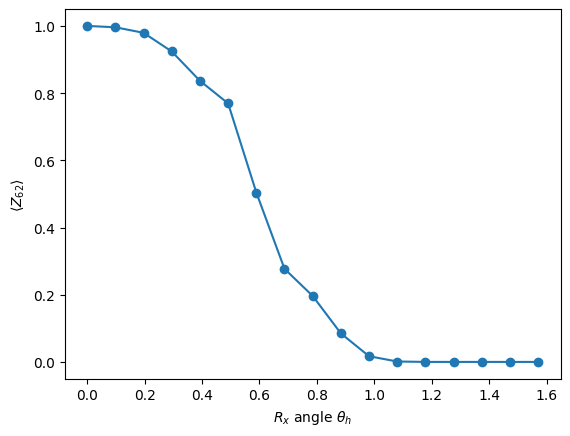

In [3]:
import matplotlib.pyplot as plt

plt.xlabel(r"$R_x$ angle $\theta_h$")
plt.ylabel(r"$\langle Z_{62} \rangle$")
plt.plot(hs, approx_evs, marker="o")